In [3]:
!pip install pystan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.5 MB/s eta 0:00:00


In [4]:
import stan
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize']=5,5
plt.style.use('ggplot')

In [5]:
# this is a work around found at
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

## Generate data
In scenarios like these, using a Gaussian mixture model enables us to model the overall distribution without knowing the specific origin of each data point. It's akin to measuring heights without prior knowledge of gender but acknowledging the potential existence of distinct groups characterized by varying means and variances. This approach helps in capturing the combined distribution and detecting potential underlying subpopulations without explicit identification of each individual's origin.

In [6]:
# Create data sampled from a mixture of gaussians
# define the parameters
np.random.seed(1)
mu0 = 2
sigma0 = 1.5
mu1 = 5
sigma1 = 1.3
p = 0.8 # mixture parameter
#sampling
out = []
bernoulli = np.random.binomial(1, p, size=1000)
for i in range(len(bernoulli)):
    if bernoulli[i] == 1:
        out.append(np.random.normal(mu0,sigma0))
    else:
        out.append(np.random.normal(mu1,sigma1))

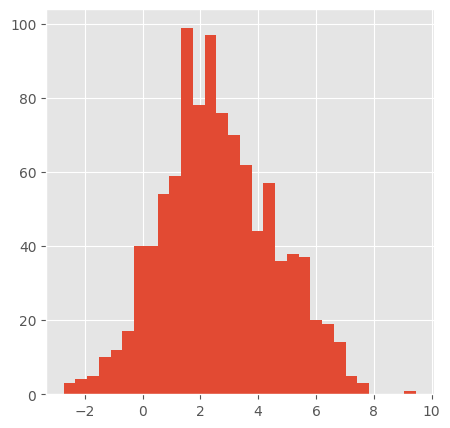

In [7]:
# We plot the data without labels (as we would actually see it!)
plt.hist(out, bins=30)
plt.show()

### Implementing the Gaussian Mixture model
This Stan code block outlines a Gaussian mixture model. It sets up parameters for two Gaussian distributions, defining means (mu[1] and mu[2]) ordered in ascending order and standard deviations (sigma[1] and sigma[2]). The theta parameter controls the mixture between these distributions. Priors are established for these parameters: normal distributions for means with a mean of 3 and standard deviation of 2, a normal distribution for standard deviations centered at 0 with a standard deviation of 2, and a beta distribution for theta, representing a uniform distribution between 0 and 1. The model iterates over observations, evaluating the likelihood of each observation under the Gaussian mixture using log_mix, which combines the probability densities of the two Gaussian distributions weighted by theta.

In [21]:
my_mixture="""
data {
 int <lower=0> N;
 vector[N] y;
}

parameters {
  ordered[2] mu;  // This tells the sampler that always mu[1] < mu[2]
  //real mu[2];   // Study what happens if we use this line instead of the above  (it is called 'label switching')
  real<lower=0> sigma[2];
  real<lower=0, upper=1> theta;
}

model {
 sigma ~ normal(0, 2);
 mu[1] ~ normal(3, 2);
 mu[2] ~ normal(3, 2);
 theta ~ beta(1, 1);  //this is a uniform flat distribution for p in (0,1)
 for (n in 1:N)
   target += log_mix(theta,
                     normal_lpdf(y[n] | mu[1], sigma[1]),
                     normal_lpdf(y[n] | mu[2], sigma[2]));
}
"""



In [22]:
my_data={'N':len(out),'y':out}

In [23]:
model = stan.build(my_mixture, data=my_data, random_seed=1);

Building...

CRITICAL:httpstan:Exception while compiling `program_code`: `ValueError("Error in '/tmp/httpstan_ws488btq/model_s42j2vxw.stan', line 10, column 2: Declaration\n    of arrays by placing brackets after a variable name was removed in Stan\n    2.33.0. Instead use the array keyword before the type. This can be\n    changed automatically using the auto-format flag to stanc")`


RuntimeError: Error in '/tmp/httpstan_ws488btq/model_s42j2vxw.stan', line 10, column 2: Declaration
    of arrays by placing brackets after a variable name was removed in Stan
    2.33.0. Instead use the array keyword before the type. This can be
    changed automatically using the auto-format flag to stanc

In [ ]:
fit = model.sample(num_chains=5, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   1% (101/10000)
Sampling:   2% (201/10000)
Sampling:   3% (300/10000)
Sampling:   4% (400/10000)
Sampling:   5% (500/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  18% (1800/10000)
Sampling:  28% (2800/10000)
Sampling:  35% (3500/10000)
Sampling:  36% (3600/10000)
Sampling:  37% (3700/10000)
Sampling:  38% (3800/10000)
Sampling:  39% (3900/10000)
Sampling:  40% (4000/10000)
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000337 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.37 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the followin

### now we could separate both gaussians

In [ ]:
df = fit.to_frame()

In [ ]:
df

parameters         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
draws                                                                           
0          -2081.286964       0.828670    0.120567          2.0           7.0   
1          -2077.875577       0.994540    0.060051          3.0           7.0   
2          -2078.692142       0.681846    0.146824          3.0           7.0   
3          -2082.049462       0.967822    0.157554          4.0          23.0   
4          -2076.124927       0.982889    0.098455          4.0          31.0   
...                 ...            ...         ...          ...           ...   
4995       -2079.793190       0.685864    0.120567          2.0           3.0   
4996       -2076.382096       0.943863    0.060051          4.0          31.0   
4997       -2079.043675       0.994879    0.146824          4.0          23.0   
4998       -2078.536829       0.992421    0.157554          3.0           7.0   
4999       -2078.768782       1.000000    0.098455          2.0           3.0   

parameters  divergent__     energy__      mu.1      mu.2   sigma.1   sigma.2  \
draws                                                                          
0                   0.0  2083.097357  2.466486  6.040714  1.805488  0.691627   
1                   0.0  2079.183856  2.210275  5.523963  1.753013  1.055584   
2                   0.0  2083.732047  1.781341  4.743379  1.408682  1.278407   
3                   0.0  2083.026385  2.057336  4.578836  1.757898  1.525309   
4                   0.0  2078.510018  2.208948  5.512449  1.616734  1.010748   
...                 ...          ...       ...       ...       ...       ...   
4995                0.0  2080.367844  2.129844  5.119786  1.552145  1.025597   
4996                0.0  2079.356726  2.076436  5.482081  1.609151  1.026468   
4997                0.0  2082.142639  2.091118  5.395731  1.581178  0.960701   
4998                0.0  2079.761037  1.855363  5.039284  1.564957  1.208919   
4999                0.0  2080.534452  1.904619  5.082025  1.469533  1.103704   

parameters     theta  
draws                 
0           0.911918  
1           0.881072  
2           0.685911  
3           0.783214  
4           0.852655  
...              ...  
4995        0.822579  
4996        0.839874  
4997        0.801554  
4998        0.782371  
4999        0.796447  

[5000 rows x 12 columns]

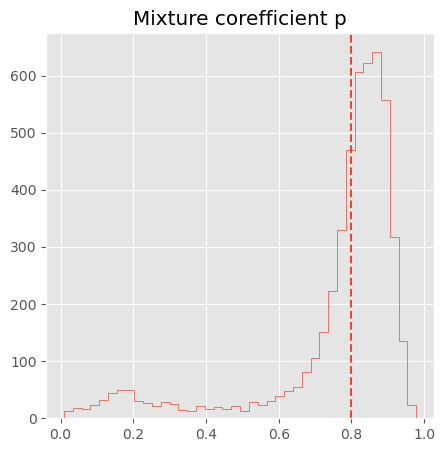

In [ ]:
plt.hist(df['theta'], histtype='step', bins=40)
plt.axvline(x=p, linestyle='dashed')
#plt.axvline(x=1-p, linestyle='dashed')
plt.title('Mixture corefficient p')
plt.show()

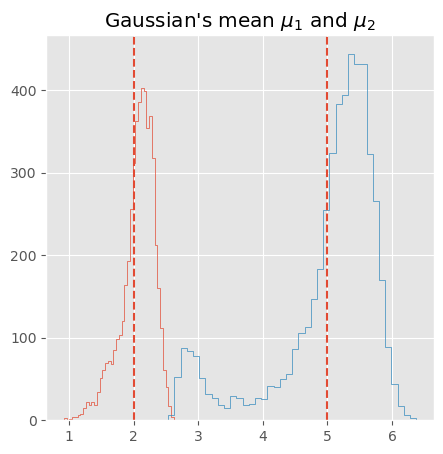

In [ ]:
plt.hist(df['mu.1'],histtype='step', bins=40, label='mu1')
plt.hist(df['mu.2'],histtype='step', bins=40, label='mu2')
plt.axvline(x=mu0, linestyle='dashed')
plt.axvline(x=mu1, linestyle='dashed')
plt.title("Gaussian's mean $\mu_1$ and $\mu_2$")
plt.show()

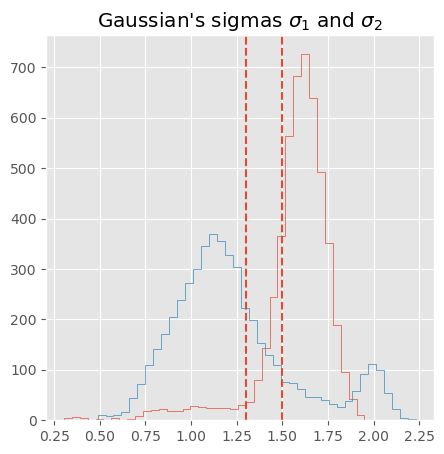

In [ ]:
plt.hist(df['sigma.1'],histtype='step', bins=40, label='sigma1')
plt.hist(df['sigma.2'],histtype='step', bins=40, label='sigma2')
plt.axvline(x=sigma0, linestyle='dashed')
plt.axvline(x=sigma1, linestyle='dashed')
plt.title("Gaussian's sigmas $\sigma_1$ and $\sigma_2$")
plt.show()